

# Predicting the condition of Texas Bridges

The data used is from the US National Bridge Inspection maintained by the Federal Highways Agency (FHWA), part of the US Department of Transportation. The aim of the Bridge Inspection programme is to check on the state of bridges so that necessary repairs can be carried out. If this is not done, a bridge can fail. The dataset has information about the bridges and the condition given in the most recent inspection.

The purpose of this Notebook is to carry out an exploratory analysis of specific variables and use regression modelling to look at the effects of said variables on a specified target variable. The predictor variables agreed upon are: age of bridge; average daily traffic of bridge (average use); the percent of traffic made up of trucks (trucks percent); material of bridge; design of bridge. These variables will be used to determine how well they predict the current condition of the bridge and to determine which one has more of an influence.

1. Section 1: Data Preparation
    1. Simplify Categories
    1. Prepare Variables
    1. Distributions
2. Section 2: Exploratory Analysis
    1. Continuous Variables
    1. Categorical Variables
    1. Continuous and Categorical Variables
    1. Preliminary Conclusions
3. Section 3: Regression Modelling
    1. Linear Regression
    1. Final Conclusions


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #additional plotting library
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## Section 1: Data Preparation

####  Section 1.1: Simplifying Categories

The agreed upon predictor variables are:
1. Age
2. Trucks Percent (% of traffic made up of trucks)
3. Average Daily (Average daily traffic)
4. Material
5. Design

The dataset, however, contains many different variables with thousands of values for each variable. As such the data needs to be prepared and condensed to begin analysis. We begin by loading the dataset.

In [ ]:
# The code below declares a categorical type with categories in a specified order
rating_type = pd.CategoricalDtype(
    categories=['Failed', 'Failing', 'Critical', 'Serious', 'Poor', 'Fair',
                'Satisfactory', 'Good', 'Very Good', 'Excellent', 'NA'],
    ordered=True)

# This one is also for an ordinal variable, but with a slightly different set of values
scour_type = pd.CategoricalDtype(
    categories=['Unknown', 'Critical','Unstable', 'Stable', 'Protected', 'Dry', 'No waterway'],
    ordered=True)

#This loads the type for each variable
types_dict = { 'Structure_id': str, 'District':'category', 'Toll':'category',
              'Maintainer':'category', 'Urban':'category', 'Status':'category',
              'Historic':'category', 'Service_under':'category', 'Material':'category',
              'Design':'category',
              'Deck_rating':rating_type, 'Superstr_rating':rating_type, 'Substr_rating':rating_type,
              'Scour_rating':scour_type}

#Loads the dataset with the previous clarifications
br = pd.read_csv('tx19_bridges_sample.csv', dtype = types_dict, index_col = 'Structure_id')
br

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,2,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,1,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,1,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150
000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,80,...,14,45.4,3.7,Good,Good,Poor,10.0,0.0,Dry,120
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,1,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,District9,0,Free,Military,Urban,Local,1994,3,0,300,...,3,45.4,19.0,Good,Good,Good,64.3,40.0,No waterway,600
DAPFORHOO000013,District9,0,Free,Military,Urban,Local,2000,2,0,300,...,1,12.3,10.8,Good,Good,Good,35.1,40.0,No waterway,600
DAPFORHOO000015,District9,0,Free,Military,Urban,Minor,1996,2,7,1200,...,4,73.2,9.8,Good,Good,Good,24.5,25.0,No waterway,1500


We begin by working with variables that do not need to be derived from other variables and are already present within the dataset. We instead look at individual variables where it has been recommended to reduce the number of categories or remove data.

It was recommended upon consultation that very old bridges are to be removed. There is a variable within the dataset titled 'Historic' which is used to categorize the bridges to determine whether they are historic and to what degree. The categories are:
1. Register
2. Possible
3. Unknown
4. Not Historic

To remove the bridges that are older, any bridges that are labelled Historic are removed from the dataset.

In [ ]:
#taken out 'Registered' historic bridges
new_bridges = br[br['Historic'] != 'Register'] #has created a new dataframe to store info
new_bridges.Historic.value_counts() # shows that there are now no Registered historic bridges in dataset

Historic
Not historic    19912
Possible        13906
Unknown            58
Register            0
Name: count, dtype: int64

Upon viewing the data for two of the predictor variables: Material and Design, it is clear that there are a few categories that contain data that has very low value counts (as shown below).

In [ ]:
new_bridges.Design.value_counts()

Design
Beam          28161
Slab           4276
Other          1239
Arch            120
Frame            52
Truss            17
Movable           8
Suspension        3
Name: count, dtype: int64

In [ ]:
new_bridges.Material.value_counts()

Material
Concrete    26924
Steel        6432
Timber        464
Other          48
Masonry         8
Name: count, dtype: int64

Although few in count the data contained is still significant, so shall not be removed. However, using these small categories for analysis would result in them being viewed as outliers and may affect values as the sizes of each category are very uneven. As a result, we condense the data to reduce the number of categories and combine multiple categories into one.

For Design, the lowest values are all added to the 'Other' category: Suspension, Movable, Truss, Frame and Arch. This reduces the number of categories from 8 with a large range down to 3 with a smaller range of values.

In [ ]:
combined_design = {'Suspension': 'Other', 'Movable': 'Other', 'Truss': 'Other', 'Frame': 'Other', 'Arch': 'Other'}

new_bridges.loc[:, 'Design'] = new_bridges['Design'].replace(combined_design)
new_bridges.Design.value_counts() # new value counts

Design
Beam     28161
Slab      4276
Other     1439
Name: count, dtype: int64

The same is then done for Material, where the 2 smallest categories, Masonry and Other, are added to 'Timber'. This reduces the number of categories from 5 down to 3.

In [ ]:
combined_material = {'Masonry': 'Timber', 'Other': 'Timber'}

new_bridges.loc[:, 'Material'] = new_bridges['Material'].replace(combined_material)
new_bridges.Material.value_counts() # new value counts

Material
Concrete    26924
Steel        6432
Timber        520
Name: count, dtype: int64

Now the data that needed to be excluded due to the adverse affects the values may have had on analysis have been removed and the variables with extra values have been condensed.

#### Section 1.2: Creating New Variables

However, of the agreed predictor variables, Material, Design, Trucks Percent and Average Daily are the only variables already present within the dataset. We do not have the Age variable and also do not have the target variable agreed upon of Current Condition. As such these new variables need to be derived.

One of the agreed-upon variables, Age, is not already present within the dataset and as such needs to be derived. This is done below by taking the variable present 'Year', which denotes the year the bridge was constructed, and calculates the age of the bridges based on that, to create the required variable: Age.

In [ ]:
current_year = pd.Timestamp.now().year
new_bridges.loc[:,'Age'] = current_year - new_bridges.loc[:,'Year']
new_bridges.Age # Created variable titled 'Age'

/tmp/ipykernel_3035/1441426877.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_bridges.loc[:,'Age'] = current_year - new_bridges.loc[:,'Year']


Structure_id
000021521-00101    18
000021521-00181    18
000021521-TMP20    11
000021525-00012    73
000021580-00092    19
                   ..
DAPFORHOO000012    29
DAPFORHOO000013    23
DAPFORHOO000015    27
DAPFORHOO00005A    32
DAPTRABLI000011    21
Name: Age, Length: 33876, dtype: int64

The most important variable is the target variable which the 5 predictor variables will be used against to determine how well the current condition of the bridge can be predicted by these variables and which of these have more of an influence on the current condition of the bridge.

The current condition of the bridge will be derived from 3 variables already present within the dataset: 'Deck Rating'; 'Superstr Rating'; 'Substr Rating'. Deck Rating rates the condition of the deck of the bridge; Superstr Rating rates the condition of the bridge superstructure and Substr Rating rates the condition of the bridge substructure. They are all rated on a scale: NA, Excellent, Very Good, Good, Satisfactory, Fair, Poor, Serious, Critical, Failing, Failed.

In order to create the target variable, the values of each rating need to be summed to determine an average score for each bridge. In order to do this, first the variables ratings are converted to number ratings.

In [ ]:
#changed ordinal variables so they have int rating values instead
new_ratings = {'NA': 0, 'Failed': 0, 'Failing': 1, 'Critical': 2, 'Serious': 3,
               'Poor': 4, 'Fair': 5, 'Satisfactory': 6, 'Good': 7, 'Very Good': 8, 'Excellent': 9}

new_bridges.loc[:, 'Deck_rating'] = new_bridges['Deck_rating'].replace(new_ratings)
new_bridges.loc[:, 'Superstr_rating'] = new_bridges['Superstr_rating'].replace(new_ratings)
new_bridges.loc[:, 'Substr_rating'] = new_bridges['Substr_rating'].replace(new_ratings)

new_bridges# shows all variables, with new rating values for the 3 above

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic,Age
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,31.4,4.3,7,8,8,41.7,0.0,Dry,1,18
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,15.5,4.3,7,7,8,41.7,0.0,Dry,1,18
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,10.1,8.4,8,8,8,48.1,0.0,Dry,150,11
000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,80,...,45.4,3.7,7,7,4,10.0,0.0,Dry,120,73
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,25.0,7.3,7,8,8,37.2,4.0,Dry,200,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,District9,0,Free,Military,Urban,Local,1994,3,0,300,...,45.4,19.0,7,7,7,64.3,40.0,No waterway,600,29
DAPFORHOO000013,District9,0,Free,Military,Urban,Local,2000,2,0,300,...,12.3,10.8,7,7,7,35.1,40.0,No waterway,600,23
DAPFORHOO000015,District9,0,Free,Military,Urban,Minor,1996,2,7,1200,...,73.2,9.8,7,7,7,24.5,25.0,No waterway,1500,27


Now the 3 variables' ratings have been converted into numerical values, we can now convert the variables themselves from categorical to continuous variables so they can then be added together. (Python does not allow for categorical variables to be added together without first converting them from categorical variables).

They are then summed to produce the target variable needed to run analysis: current condition.

Note: 'Substr Rating' could not be converted directly from categorical to continuous. So a new column holding the numerical ratings had to be created titled 'Substr new rating' which was then used with the other 2 variables to create the current condition variable.

In [ ]:
#convert categorical variables to numerical
new_bridges.loc[:,'Deck_rating'] = new_bridges['Deck_rating'].cat.codes
new_bridges.loc[:,'Superstr_rating'] = new_bridges['Superstr_rating'].cat.codes

#create new column Substr_new_rating which holds numerical ratings
new_bridges.loc[:,'Substr_new_rating'] = pd.to_numeric(new_bridges.loc[:,'Substr_rating'], errors='coerce')
new_bridges.loc[:,'Substr_new_rating'] = new_bridges['Substr_new_rating'].astype('int8')

new_bridges.loc[:,'current_condition'] = new_bridges.loc[:,'Deck_rating'] + new_bridges.loc[:,'Superstr_rating'] + new_bridges.loc[:,'Substr_new_rating']
#new_bridges.current_condition.value_counts(ascending=True)

new_bridges.info() # can view how the variables have changed in type

<class 'pandas.core.frame.DataFrame'>
Index: 33876 entries, 000021521-00101 to DAPTRABLI000011
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   District           33876 non-null  category
 1   Detour_Km          33876 non-null  int64   
 2   Toll               33876 non-null  category
 3   Maintainer         33876 non-null  category
 4   Urban              33876 non-null  category
 5   Status             33876 non-null  category
 6   Year               33876 non-null  int64   
 7   Lanes_on           33876 non-null  int64   
 8   Lanes_under        33876 non-null  int64   
 9   AverageDaily       33876 non-null  int64   
 10  Historic           33876 non-null  category
 11  Service_under      33876 non-null  category
 12  Material           33876 non-null  category
 13  Design             33876 non-null  category
 14  Spans              33876 non-null  int64   
 15  Length             33876 non-null 

/tmp/ipykernel_3035/116380939.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_bridges.loc[:,'Substr_new_rating'] = pd.to_numeric(new_bridges.loc[:,'Substr_rating'], errors='coerce')
/tmp/ipykernel_3035/116380939.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_bridges.loc[:,'current_condition'] = new_bridges.loc[:,'Deck_rating'] + new_bridges.loc[:,'Superstr_rating'] + new_bridges.loc[:,'Substr_new_rating']


Now, the target variable has been created and the predictor variables adjusted ready for analysis.

#### Section 1.3: Distributions

Variables have been derived and others adjusted. However, the data for each variable needs to be reviewed: the distribution especially. As the distribution of each variable will have a large effect on how the analysis runs and the outcomes. The continuous variables are displayed as histograms below and categorical with bar charts.

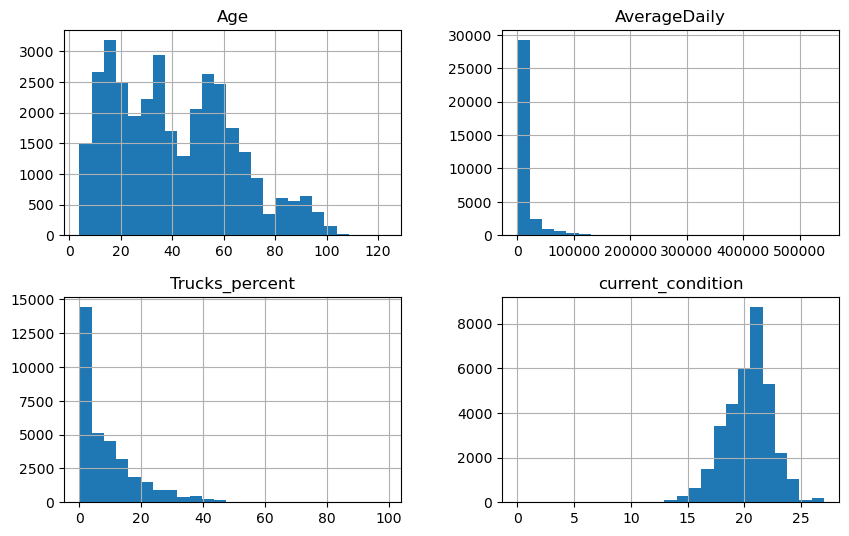

In [ ]:
continuous = ['Age', 'AverageDaily', 'Trucks_percent', 'current_condition']
_cd = new_bridges[continuous].hist(bins=25, figsize=(10,20), layout=(6,2))

The histograms are used on the continuous variables to show proportion in a range with the y axis showing frequency of a specific value. The proportion is determined by dividing the y by the x value. The distributions of all the continuous variables are positively skewed, except current condition which is negatively skewed.

Average Daily has the majority of bridges having a low count, with few bridges with a daily traffic higher than 50,000. As a result, most of the bridges appear to have a low daily traffic so although it would be expected that having higher traffic on a bridge would have a negative correlation with current condition, it may be difficult to determine this with such few high count values. As shown below the extreme values may seem like outliers especially with counts of one only but some bridges are more likely to be used than others so they are extreme but plausible values.

In [ ]:
high_AD = new_bridges[new_bridges['AverageDaily'] > 50000]['AverageDaily']
high_AD.value_counts(ascending=True)

AverageDaily
175070     1
94300      1
151120     1
86870      1
86500      1
          ..
94130     16
99560     16
60000     17
64000     19
66080     20
Name: count, Length: 700, dtype: int64

<Axes: xlabel='Material'>

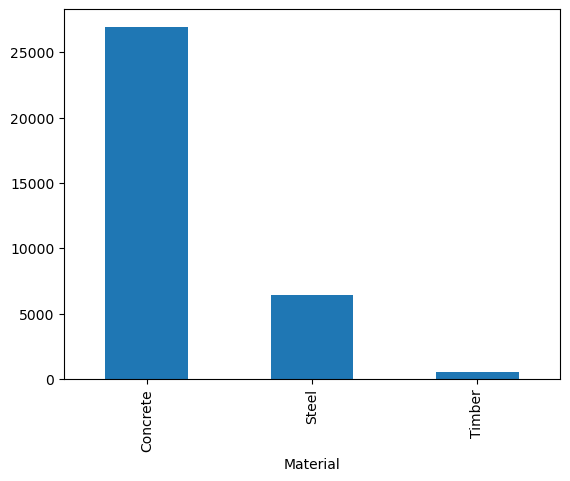

In [ ]:
#Material distributions
gbyMaterial = new_bridges.groupby(by= 'Material', dropna=False)

gbyMaterial.size().plot(kind='bar', logy=False)

The highest frequency of values in Material lies in the category Concrete with almost 3x the frequency of Steel. Timber is a combination of multiple categories but is still a vastly smaller category in comparison.

<Axes: xlabel='Design'>

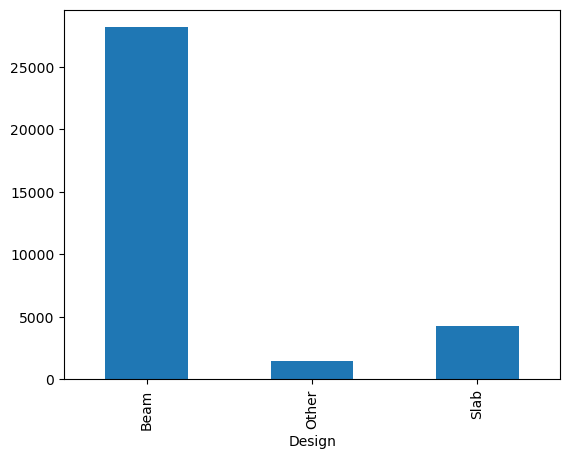

In [ ]:
#Design distributions
gbyDesign = new_bridges.groupby(by='Design', dropna=False)

gbyDesign.size().plot(kind='bar', logy= False)

The distribution of Design is much alike Material in that there  is only vastly larger category (Beam) with Slab and Other having smaller frequency counts. Other is a culmination of a few categories but is still alot smaller than the other two categories. Due to the higher frequency count it is likely that Beam will have a larger predictive capability on current condition in comparison to the other 2 categories.

## Section 2: Exploratory Analysis

Now that the data needed for analysis has been prepped, a preliminary analysis can be conducted on the variables to determine the relationships between each and how they may affect the target variable, before the regression is run.

As shown below, the predictor variables and the target variable is displayed with a brief explaination of what each entails and the type of variable it is. Material and Design are categorical variables so analysis will begin with the continuous variables.

#### Predictor Variables

| Variable | Description and Values | Type |
|:---------:|:-----------|:-------|
| Age | How old the bridge is in years | Continuous |
| Average Use | Average daily traffic (no of vehicles) | Continuous |
| Percent Trucks | The % of traffic made up of 'trucks' | Continuous |
| Material | The main material the bridge is made from | Categorical |
| Design | The design of the bridge | Categorical |

#### Target Variable
| Variable | Description and Values | Type |
|:---------:|:-----------|:-------|
| Current Condition | Condition of the bridge based on deck, superstructure and substructure (foundations) as a rating | Continuous |
|     |                   |              |


#### Section 2.1: Continuous Variables

In order to be able to run the regression successfully, we need to see how each of the predictor variables correlates not just to the target variable, but also to each other. The relationship between the chosen predictor variables is just as important as the correlation of them to current condition, especially as we want to ensure that the predictor variables are not showing issues of multicollinearity and to ensure they are independent variables. If multicollinearity is present, it will produce issues with the regression analysis as it will make it difficult to determine the individual effects of each predictor variable.

First, we check that the continuous variables show no signs of multicollinearity by looking at how highly correlated they are to each other through a correlation matrix. Any variables with a correlation higher than 0.7 is cause for concern.

In [ ]:
#correlation matrix for all continuous variables
new_bridges[continuous].corr(numeric_only=True)

,Age,AverageDaily,Trucks_percent,current_condition
Age,1.000000,-0.052826,0.229289,-0.588231
AverageDaily,-0.052826,1.000000,0.022889,0.034732
Trucks_percent,0.229289,0.022889,1.000000,-0.048216
current_condition,-0.588231,0.034732,-0.048216,1.000000


There are no sign of multicollinearity as the correlation coefficients are not very high. Thus, we can look at how the variables all relate to each other and how.

In order to visualise this better, we then use this correlation matrix to create a heat map with the correlation values produced.

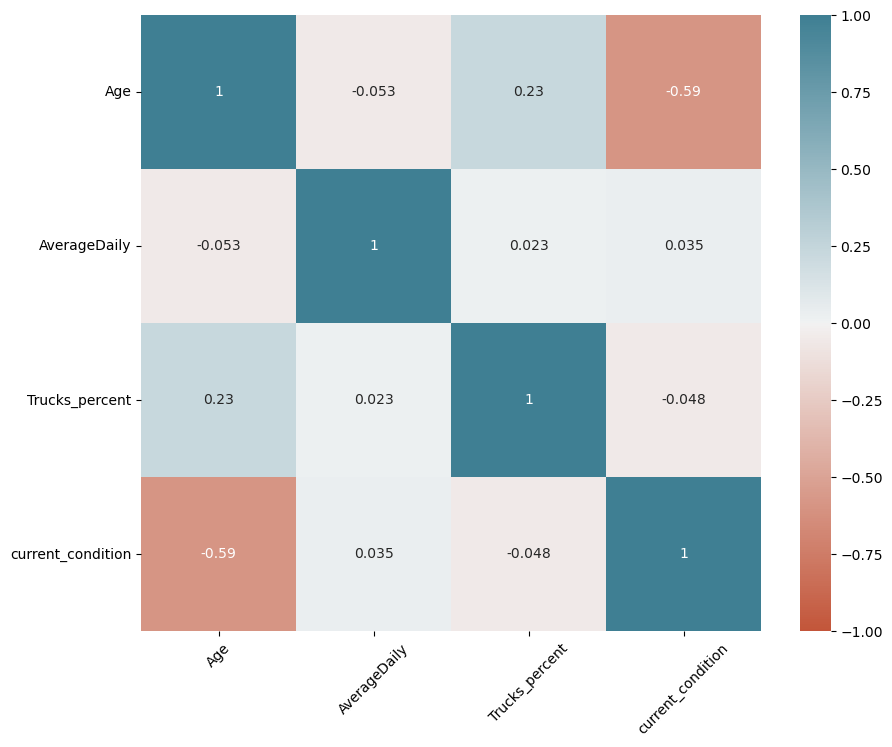

In [ ]:
#correlation matrix into heat map
fig,ax = plt.subplots(1,1, figsize=(10,8))
sns.heatmap(new_bridges[continuous].corr(numeric_only=True), vmin =-1, vmax =1, cmap=sns.diverging_palette(20,220, as_cmap=True),
            annot=True, ax=ax, annot_kws={'size':10})
_y = plt.yticks(rotation=0, fontsize=10)
_x = plt.xticks(rotation=45, fontsize=10)

The diagonal shows the correlation of the values against themselves (so it equates to 1). The highest correlation coefficient with the target variable is Age, which has a moderate negative correlation of -0.59. Average Daily and Trucks Percent have a negligable correlation coefficient with current condition as they are below 0.1 and -0.1 respectively.

Of the continuous predictor variables, they have little relationship to each other. There are no signs of multicollinearity as a result. The only two predictor variables that have a correlation coefficient above .01 is Age and Average Daily with a value of 0.23, which is a very weak relation. The other continuous predictor variables all have positive or negative coefficients less than .01. As a result all of these variables can be used in the regression analysis, with confidence that they have independent effects.

#### Section 2.2: Categorical Variables

Now having examined the nature and strength of the categorical variables relationships between each other and the target variable, we can examine the categorical variables: Material and Design. Unlike the continuous variables these have to be plotted in a different way to show the relationship between variables and also compare the difference between the categories within the variables. The relationship between the 2 categorical predictor variables are explored first.

We first cross tabulate the variables in a contingency table. The crosstab table below shows the joint probability, which normalizes over all values to create a joint probability distribution, over all values.

In [ ]:
#joint probability
des_mat = pd.crosstab(new_bridges.Material, [new_bridges.Design], normalize='all')
des_mat.round(4)* 100

Design,Beam,Other,Slab
Material,,,
Concrete,63.82,3.04,12.62
Steel,17.94,1.04,0.00
Timber,1.37,0.17,0.00


The normalize ='all' normalizes all values by dividing all values by the sum of the values. This as a result gives the relative proportions of each combination. The highest related categories among the two variables are Concrete and Beam, which is indicative of the large frequency of values within both categories: they are both the largest categories within each variable. For the Concrete material, the Beam design accounts for 63.82% of occurances. It is the largest occurance. Slab and Steel and Timber and Slab do not have any occurances, thus no relationship. This is largely due to the lack of value counts in comparison to the other categories.

Again, another two crosstab tables have been created below. They show the relationship between the two categorical variables in a different way, through conditional probabilities. The difference is apparent through the use of normalize ='index' instead of 'normal'. Using index instead, normalizes the values by dividing all values by the sum of values in each row.

In [ ]:
#conditional probabilities
des_and_mat = pd.crosstab(new_bridges.Design, [new_bridges.Material], normalize='index')
mat_and_des = pd.crosstab(new_bridges.Material, [new_bridges.Design], normalize='index')

In [ ]:
des_and_mat.round(4) * 100

Material,Concrete,Steel,Timber
Design,,,
Beam,76.77,21.58,1.65
Other,71.51,24.60,3.89
Slab,100.00,0.00,0.00


This crosstab table shows the proportion of each Material category for each Design category in percentages. It is read by the rows summing to 100. For the Concrete material, Beam makes up 76.77%, Steel is 21.58 % and Timber is 1.65%. This is reasonable as both Beam and Concrete are the largest categories within both variables. Other is made up primarily of Concrete, with almost 1/4th of occurances being Steel. Slab Material is made up 100% of Concrete.

In [ ]:
mat_and_des.round(4) * 100

Design,Beam,Other,Slab
Material,,,
Concrete,80.30,3.82,15.88
Steel,94.50,5.50,0.00
Timber,89.23,10.77,0.00


This final crosstab table shows the distribution of Design categories for each Material category, with Beam once again making up the majority proportion for each Material category.

The crosstabulation is not indicative of whether there is any multicollinearity between the two categorical variables so the conducting of a correlation ratio is undertaken below (much like the correlation matrix for the continuous variables).

In [ ]:
from scipy.stats import chi2_contingency

material= new_bridges['Material']
design = new_bridges['Design']

# Compute the contingency table
contingency_table = pd.crosstab(material, design)

# Calculate the correlation ratio
chi2, p, dof, ex = chi2_contingency(contingency_table)
cr = np.sqrt(chi2 / (len(material)*(min(len(contingency_table)-1, len(contingency_table.columns)-1))))

print("Correlation Ratio:", cr)


Correlation Ratio: 0.1395722509685392


The correlation ratio shows a very weak positive relationship between the two variables. As a result there is no multicollinearity between the categorical variables, so they are also independent varaibles that can be used within the regression.

#### Section 2.3: Continuous and Categorical Variables

The categorical variables' exploratory analysis has been conducted against each other, but the categorical variables' relationship against the other continuous predictor variables and the continuous target variable, also need to be conducted.

To begin with, the relationship between Material and Design against the target variable, current condition, is explored. This is done via boxplots to show the distribution of the categories of each categorical variable across current condition.

Text(0, 0.5, 'Current Condition Rating')

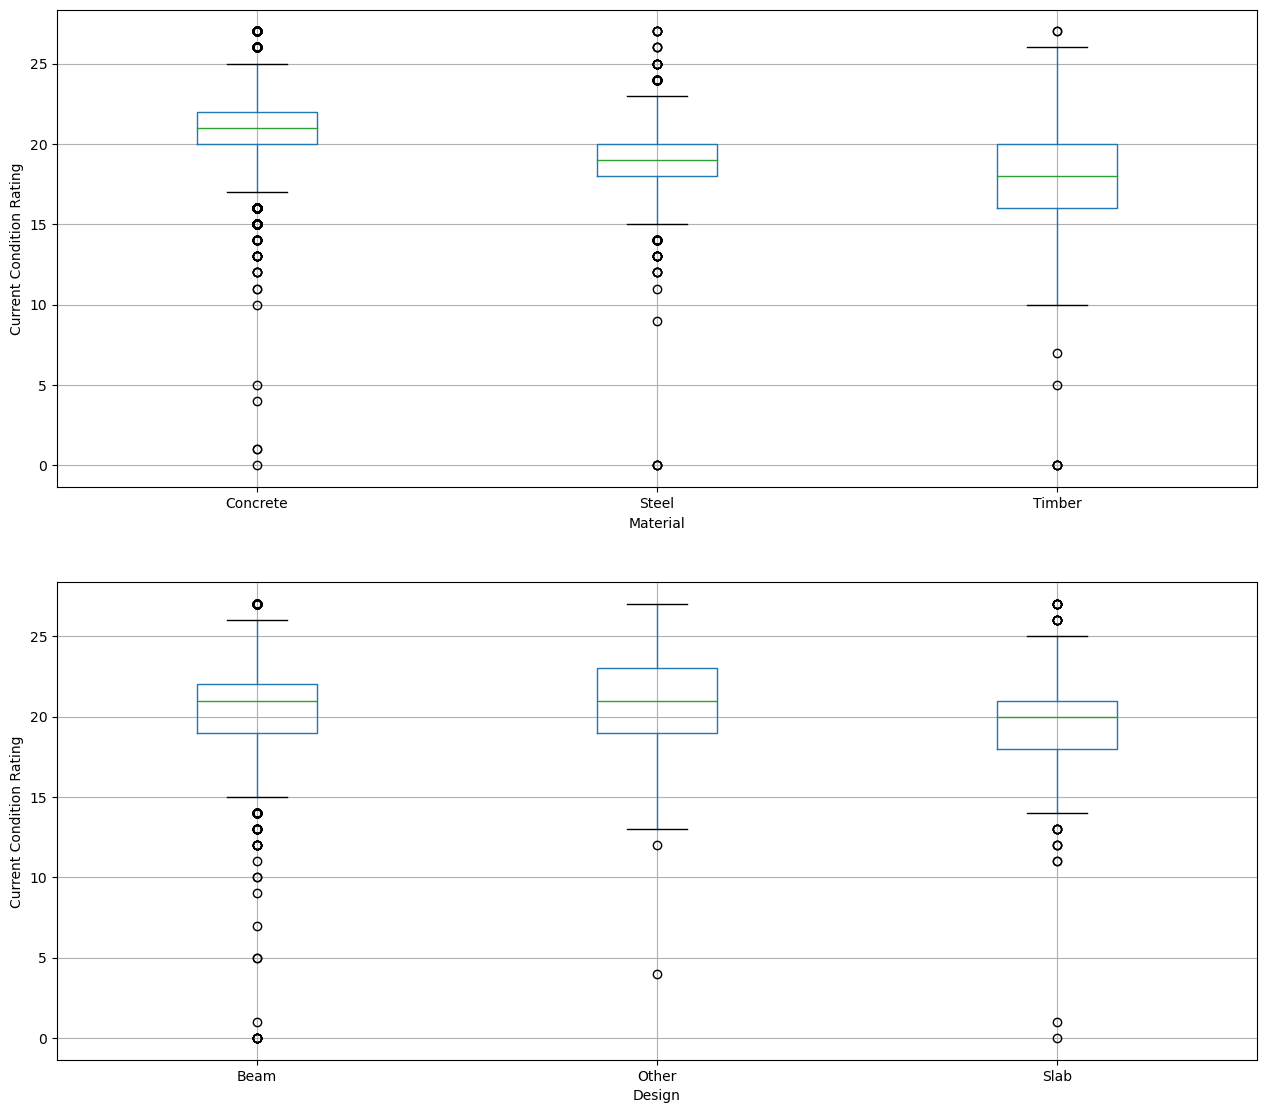

In [ ]:
fig, (a1, a2) = plt.subplots(2,1, figsize=(15,14))

new_bridges.boxplot(column='current_condition', by='Material', ax=a1, showfliers=True)
new_bridges.boxplot(column='current_condition', by='Design', ax=a2, showfliers=True)

# #label graphs
fig.suptitle('')
[a.set_title('') for a in [a1, a2]]
a1.set_ylabel('Current Condition Rating')
a2.set_ylabel('Current Condition Rating')

These boxplots show the distribution of current condition for each category within the categorical variables. The distribution of the Material categories is fairly symmetrical for each of the categories with the median in the centre of the box and the whiskers being the same on either side. The interquartile range for Timber is alot larger than for the other 2 categories in Material. There appears to be alot of datapoints that lie outside of the boxplot and could be considered as outliers but as previously discussed, they are extreme values with fewer counts but are plausible so will not be removed.

The distribution for Design is not as symmetrical with Beam and Slab being negatively correlated to current condition with negative skew being shown. The whiskers are fairly symmetrical for all categories with Other having the largest spread of data. All categories have a similar relationship with current condition.

They have also been visualised below using overlapping histograms to see directly the spread of each category for current conditions in relation to each other. Unlike the boxplots, all points are plotted and included within the shape of the distribution.

Text(0.5, 0, 'Current condition rating')

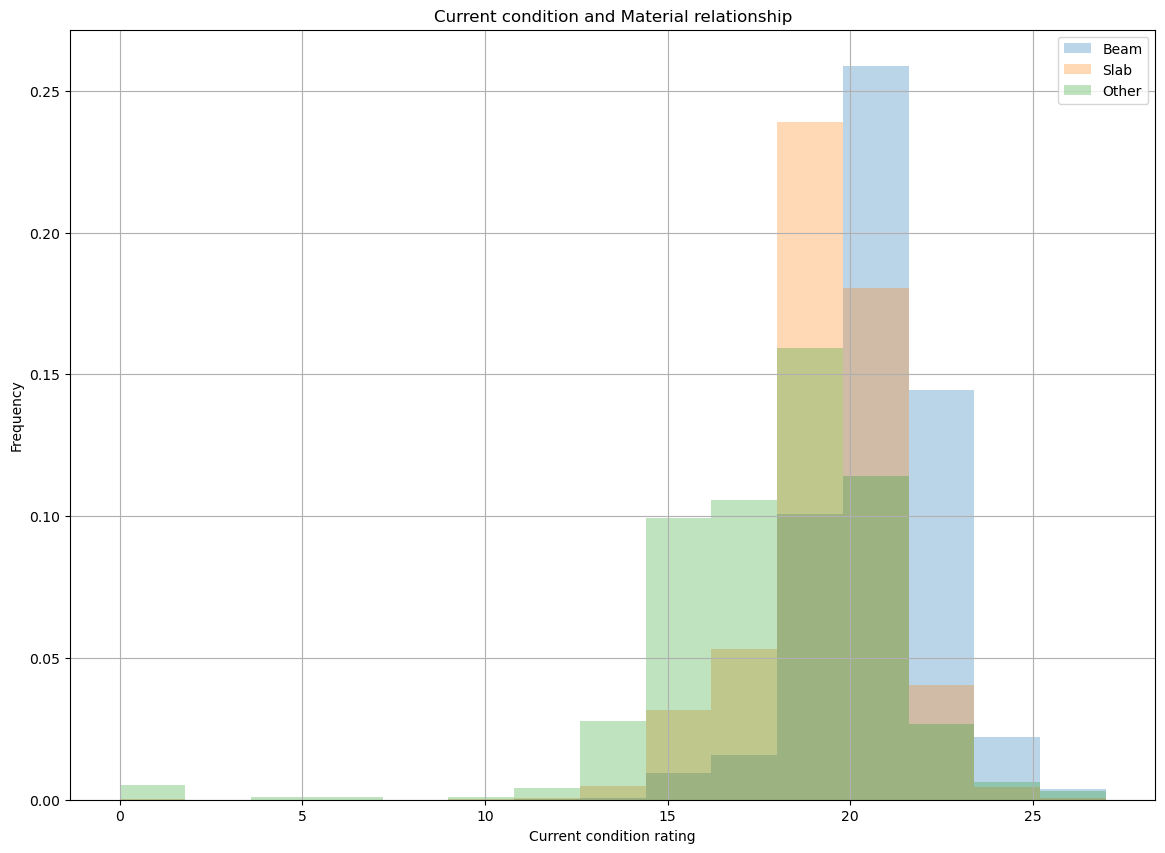

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(14,10))

# plot the histogram using these axes
_x = gbyMaterial.hist(column=['current_condition'], ax = axs, alpha=0.3, bins=15, density=True) #, log=True)

# Set a legend, using the group names
name = ['Beam', 'Slab', 'Other']
axs.legend(name)

axs.set_title('Current condition and Material relationship')
axs.set_ylabel('Frequency')
axs.set_xlabel('Current condition rating')

This histogram shows the distribution for each category displayed through the different colours and the overlap. The categories individually are binomial with one peak but combined Material is multimodal in relation to current condition rating.

The graph below shows the same for Design.

Text(0.5, 0, 'Current condition rating')

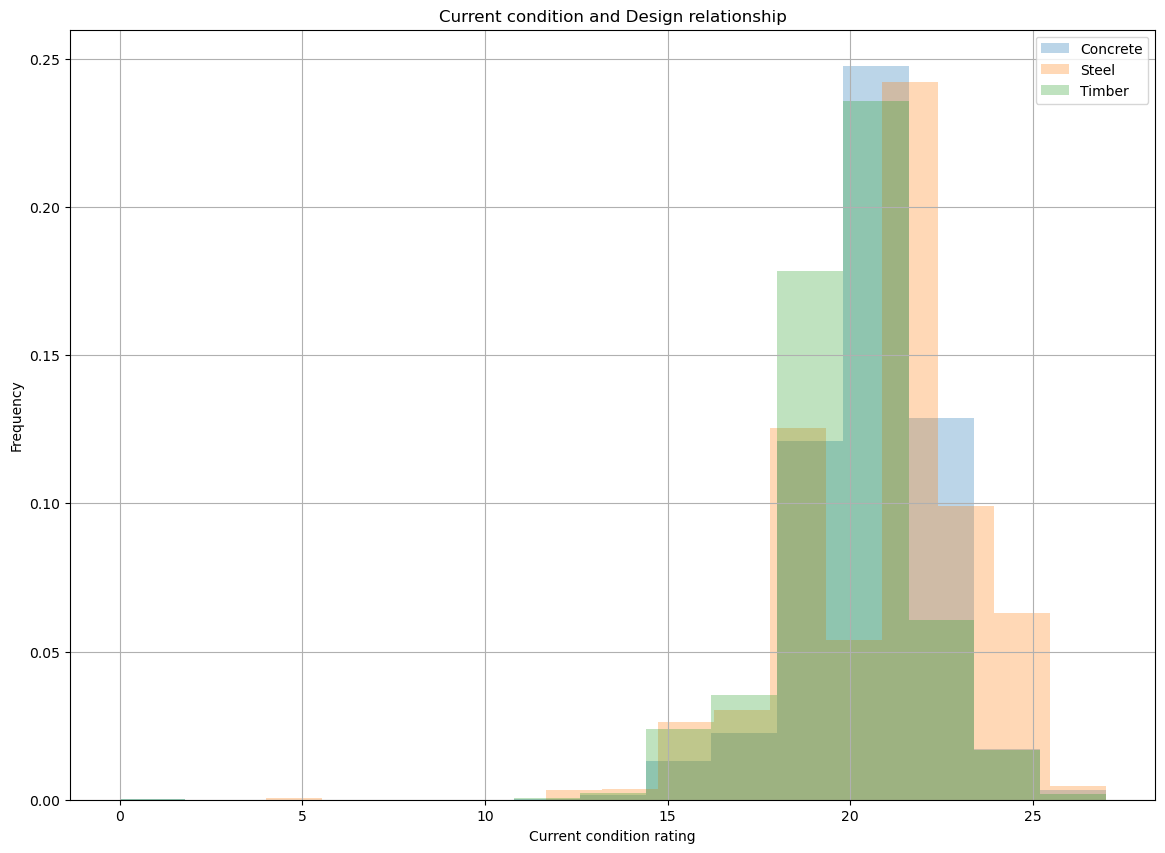

In [ ]:
# Create the figure
fig, axs = plt.subplots(1,1, figsize=(14,10))

# plot the histogram using these axes
_x = gbyDesign.hist(column=['current_condition'], ax = axs, alpha=0.3, bins=15, density=True) #, log=True)

# Set a legend, using the group names
name = ['Concrete', 'Steel', 'Timber']
axs.legend(name)
#label graph
axs.set_title('Current condition and Design relationship')
axs.set_ylabel('Frequency')
axs.set_xlabel('Current condition rating')

This histogram shows the distribution for each category displayed through the different colours and the overlap. The categories individually are binomial with one peak and combined has one clear peak. Unlike Material, which had some trailing data points, Design is distributed almost all towards the right-hand side, showing that it is left-skewed. Te high overlap suggests that the association between current condition and both the categorical categories is not strong.

The categorical variables relationship with the target variable has been explored now. Unlike the continuous predictor variables which were all viewed against each other to see the relationship between them, this has not been done for the categorical predictors against the continuous predictors. This will now be explored beginning with Age in relation to Material and Design.

<Axes: title={'center': 'Age'}, xlabel='Design'>

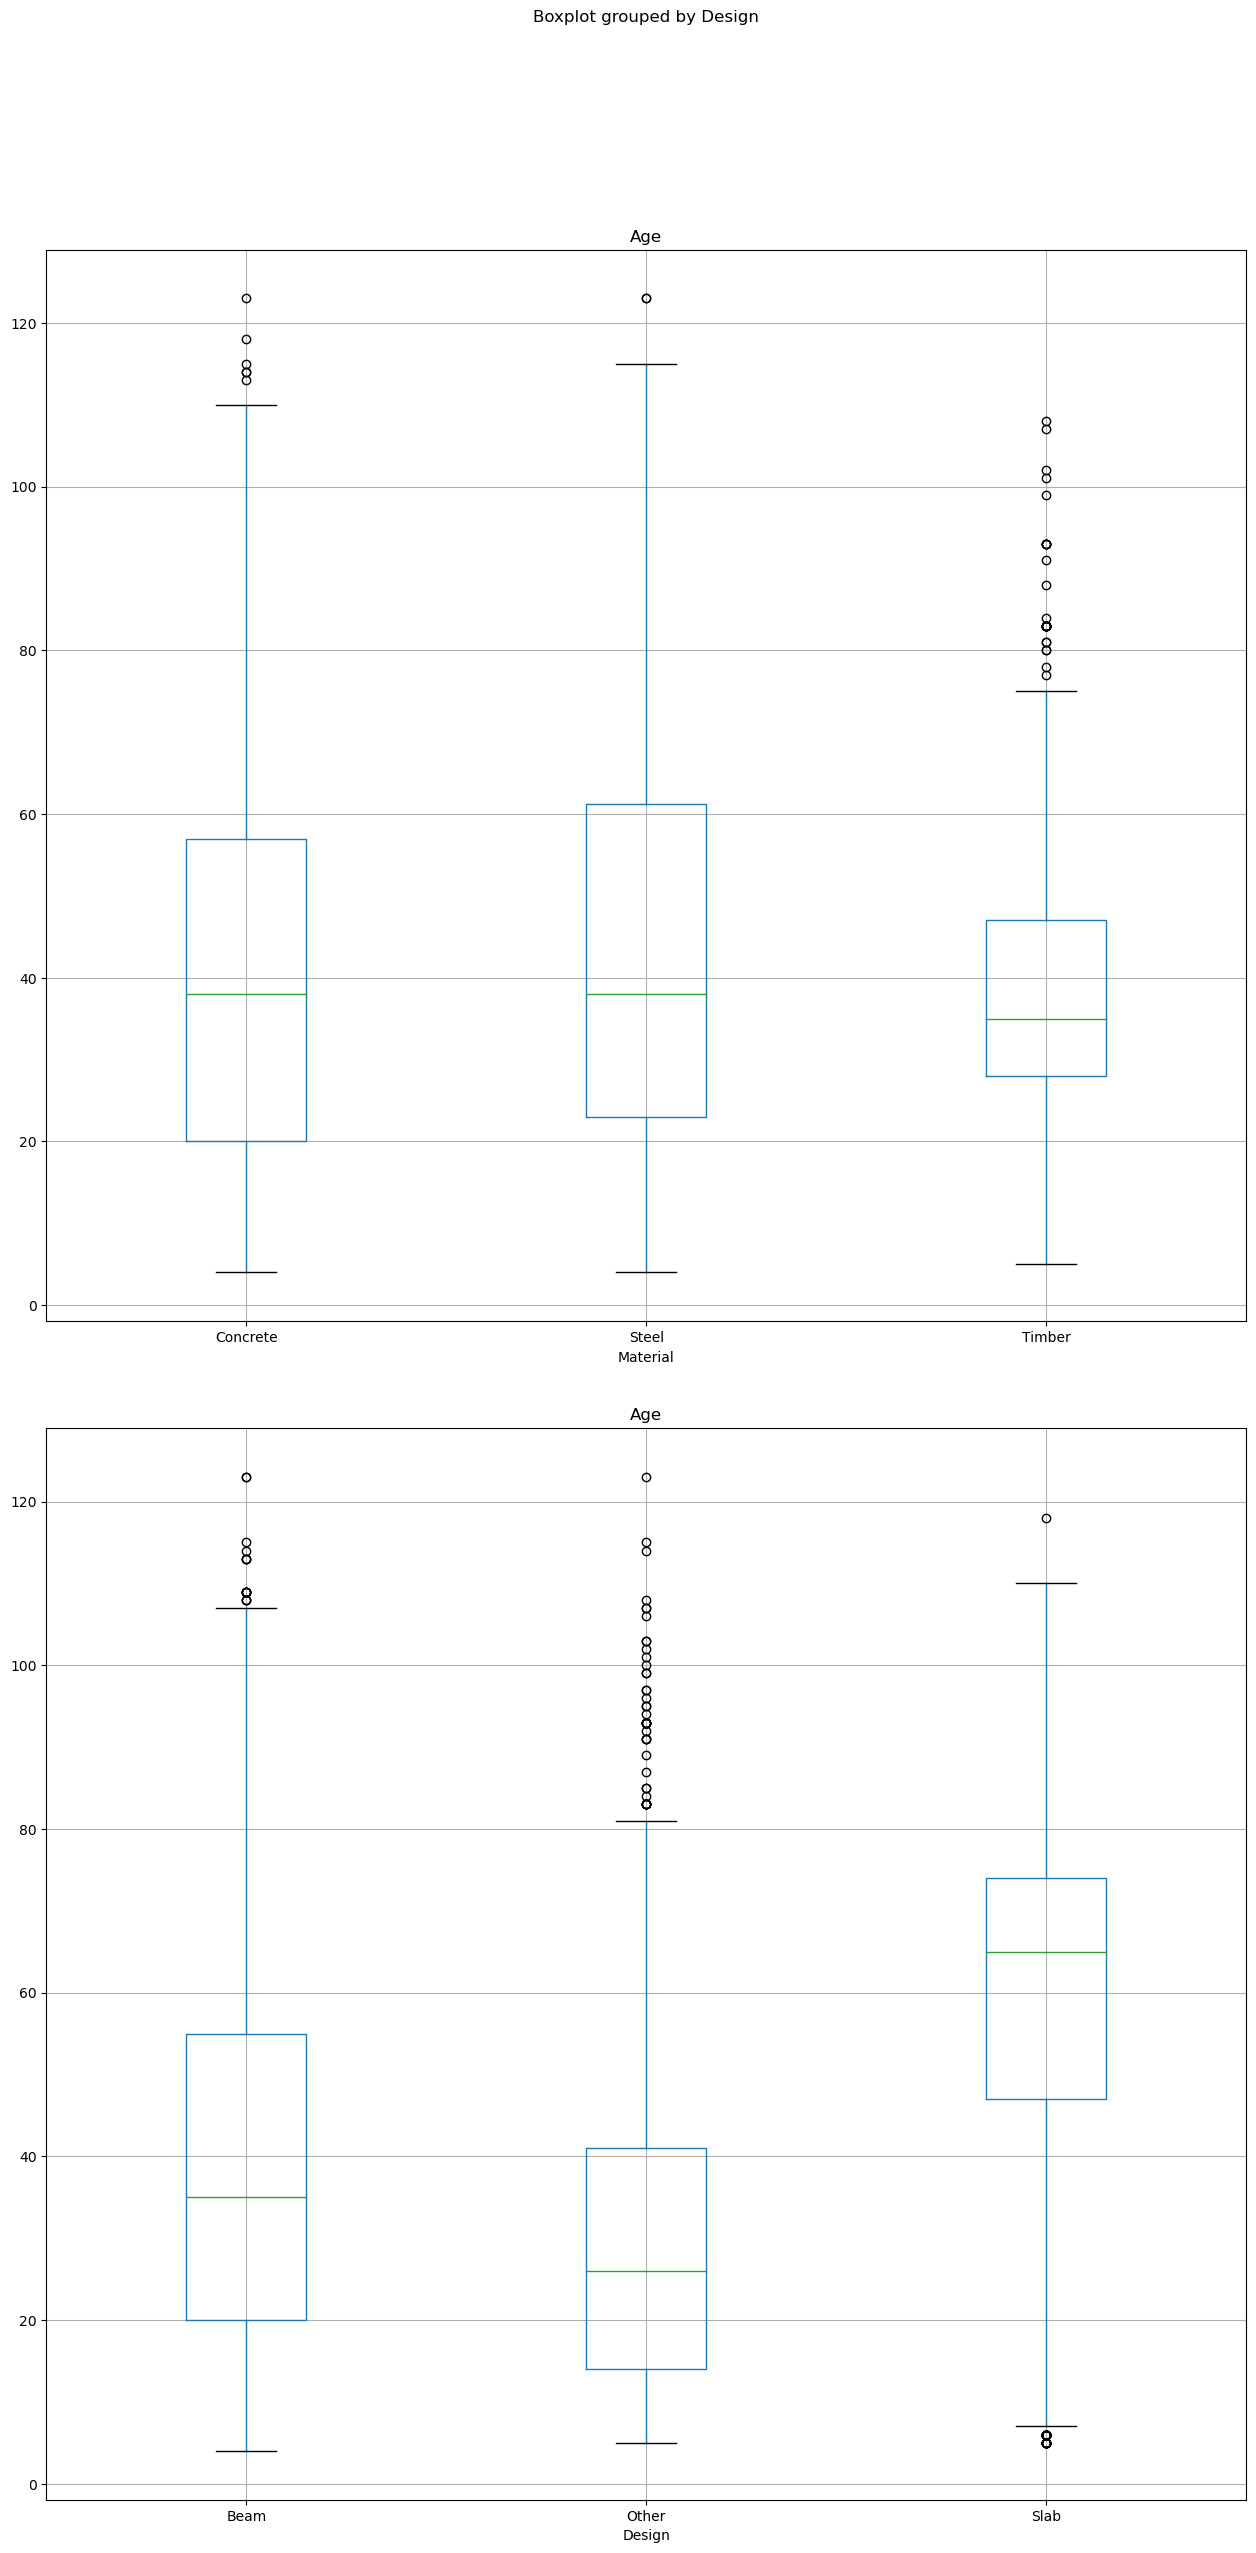

In [ ]:
fig, (a1, a2) = plt.subplots(2,1, figsize=(15,30))
fig.subplots_adjust(hspace=0.1)

new_bridges.boxplot(column='Age', by='Material', ax=a1)
new_bridges.boxplot(column='Age', by='Design', ax=a2)

The relationship between Age and Material is shown in the first 3 side-by-side boxplots, where there is alot of overlap. Overlap in boxplots alludes to a low association between the variables. Medians for each category within Material are all fairly similar. The whiskers all vary in size, and show a higher upper spread of data for both Concrete and Steel. Timber is mainly symmetrical. There is likely little relationship between Age and Material as as result.

The relationship between Age and Design is seen in the lower 3 side-by-side boxplots, where this is less overlap. The box of Slab does not overlap with the box of Other at all, but Beam overlaps with both (the lower quartile with Other and upper quartile with Slab). The overlap does suggest that there is a low association between variables but it is slightly higher than Age and Material.  The whiskers all vary in size, and show a higher upper spread of data for all categories, except Slab which has fairly symmetrical whiskers.

We now need to explore the relationship between the categorical variables and the remaining continuous variables. However, as shown in the histograms in Section 1, they are heavily skewed in distribution. This will make it harder to analyse the relationship, so in order to rectify this, we will create a new dataframe with extra columns containing the logarithms of the variables, to make it easier to view a relationship between the variables.

In [ ]:
brd_logs = new_bridges.assign(AverageDailyLog = np.log10(new_bridges.AverageDaily),
                              Trucks_percentLog = np.log10(new_bridges.Trucks_percent))
brd_logs

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic,Age,Substr_new_rating,current_condition,AverageDailyLog,Trucks_percentLog
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,8,41.7,0.0,Dry,1,18,8,23,0.000000,-inf
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,8,41.7,0.0,Dry,1,18,8,22,0.000000,-inf
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,8,48.1,0.0,Dry,150,11,8,24,2.000000,-inf
000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,80,...,4,10.0,0.0,Dry,120,73,4,18,1.903090,-inf
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,8,37.2,4.0,Dry,200,19,8,23,2.176091,0.602060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,District9,0,Free,Military,Urban,Local,1994,3,0,300,...,7,64.3,40.0,No waterway,600,29,7,21,2.477121,1.602060
DAPFORHOO000013,District9,0,Free,Military,Urban,Local,2000,2,0,300,...,7,35.1,40.0,No waterway,600,23,7,21,2.477121,1.602060
DAPFORHOO000015,District9,0,Free,Military,Urban,Minor,1996,2,7,1200,...,7,24.5,25.0,No waterway,1500,27,7,21,3.079181,1.397940


These new values we have made will make it easier to plot the continuous variables against the categorical variables to be able to view the relationship between these predictor variables and ensure they are all independent and can be used within the regression.

<Axes: title={'center': 'AverageDailyLog'}, xlabel='Material'>

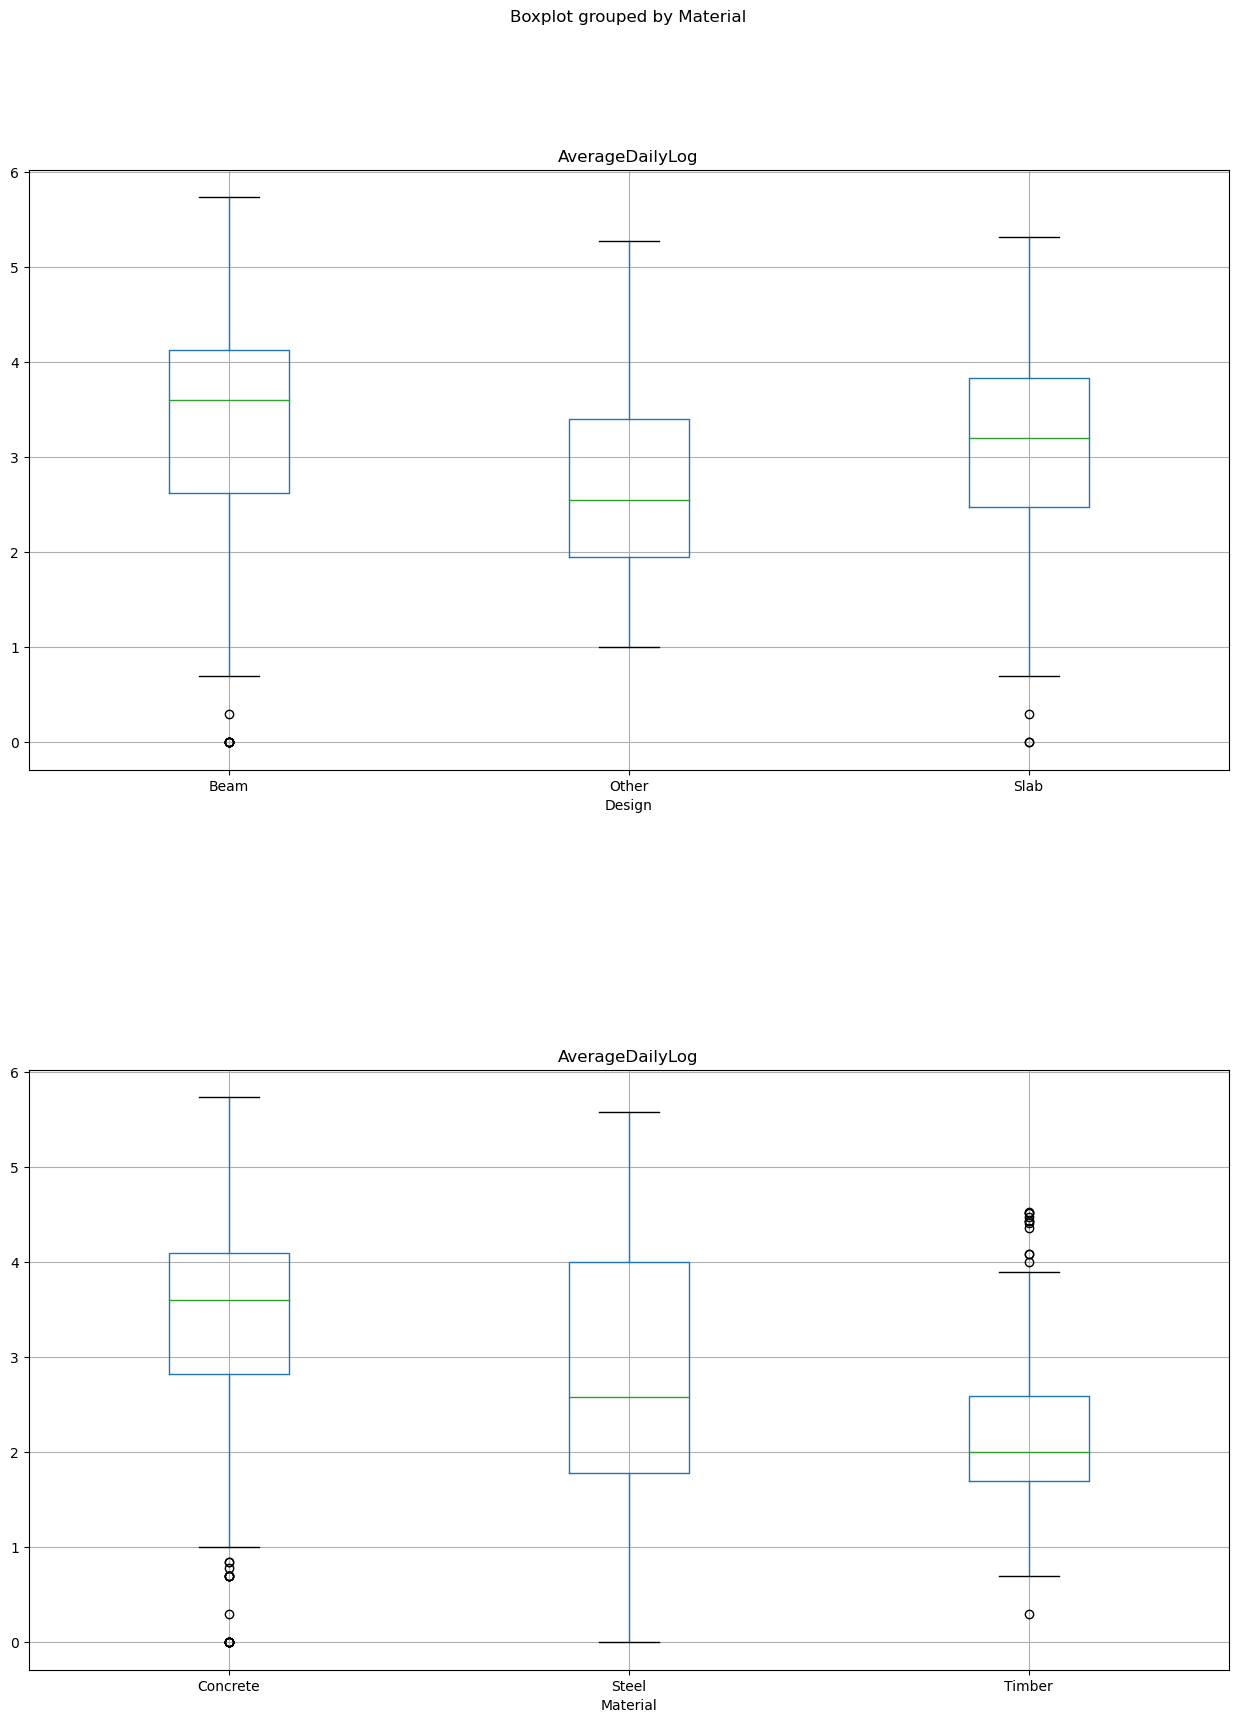

In [ ]:
fig, (a1, a2) = plt.subplots(2,1, figsize=(15,20))
fig.subplots_adjust(hspace=0.5)

brd_logs.boxplot(column='AverageDailyLog', by='Design', ax=a1)
brd_logs.boxplot(column='AverageDailyLog', by='Material', ax=a2)

The relationship between Average Daily and Design is seen in the upper 3 side-by-side boxplots, where this is alot of overlap within the 3 boxes. All 3 boxes overlap with Slab and Beam being very similar in size and position, and Other being slightly lower. However, the whiskers are all fairly symmetrical with no extreme outliers. This shows that the two variables are likely to be independent of each other.

The relationship between Average Daily and Material is seen in the lower 3 side-by-side boxplots, where  there is less overlap. Steel's lower quartile matches Timbers lower quartile, and Steels median lies on the same line as Timbers upper quartile. Steel and Timber are both positively skewed, and Steel and Concrete have similar length whiskers. The overlap does suggest that there is a low association between variables but it is slightly higher than AverageDaily and Design.

Text(0.5, 0, 'Trucks Percent Log')

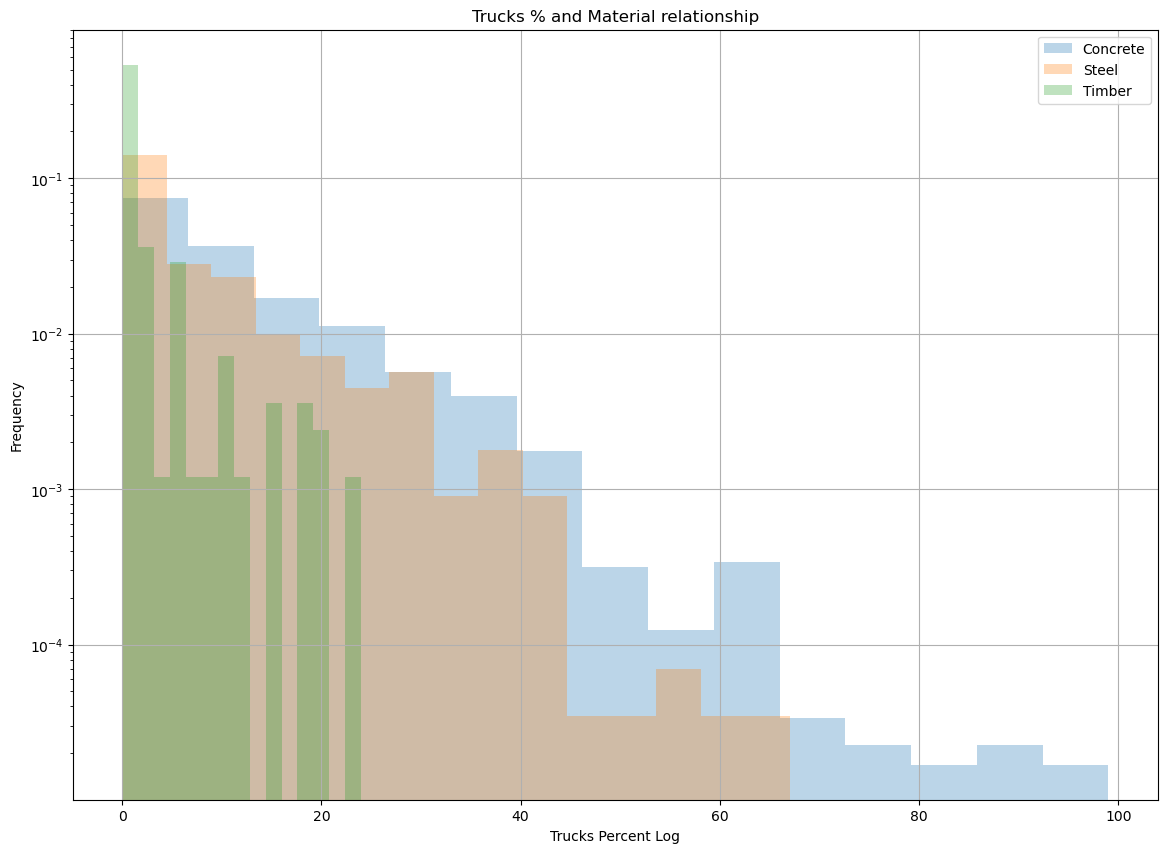

In [ ]:
# Create the figure
fig, axs = plt.subplots(1,1, figsize=(14,10))

# plot the histogram using these axes
_x = gbyMaterial.hist(column=['Trucks_percent'], ax = axs, alpha=0.3, bins=15, density=True, log=True)

# Set a legend, using the group names
name = ['Concrete', 'Steel', 'Timber']
axs.legend(name)
#label graph
axs.set_title('Trucks % and Material relationship')
axs.set_ylabel('Frequency')
axs.set_xlabel('Trucks Percent Log')

Text(0.5, 0, 'Trucks Percent')

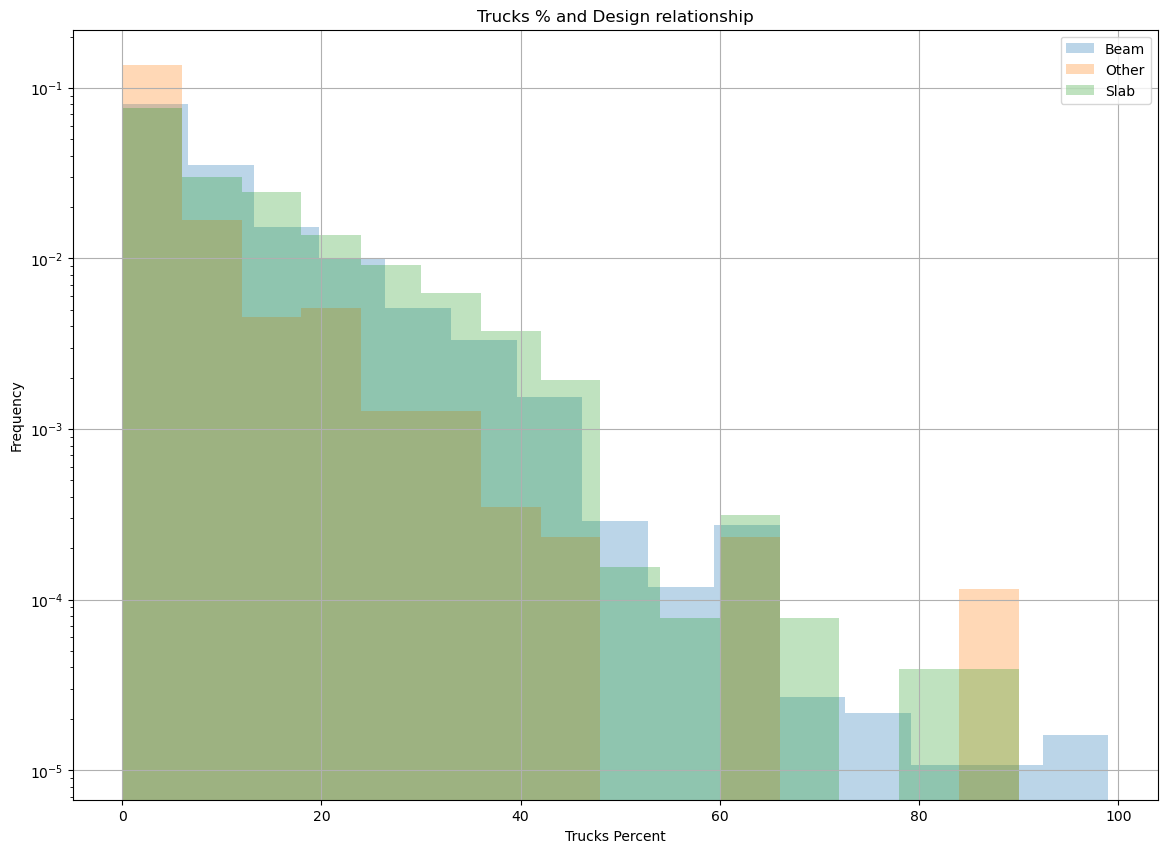

In [ ]:
# Create the figure
fig, axs = plt.subplots(1,1, figsize=(14,10))

# plot the histogram using these axes
_x = gbyDesign.hist(column=['Trucks_percent'], ax = axs, alpha=0.3, bins=15, density=True, log=True)

# Set a legend, using the group names
name = ['Beam', 'Other', 'Slab']
axs.legend(name)
#label graph
axs.set_title('Trucks % and Design relationship')
axs.set_ylabel('Frequency')
axs.set_xlabel('Trucks Percent')

Once again we used overlapping histograms to explore the relationships between Material and Trucks percent (top). As Trucks percent is heavily skewed we used 'log=True' to use the logarithmic values of the variable to plot (this meant we did not have to use the brd_logs variable 'Trucks_percentLog'). There is heavy overlap between the groups showing lack of a strong relation between the continuous and categorical variable. The graph is still distributed and shown as skewed but using the log values has made it easier to view peaks and specific value counts in the variables. They are independent of each other. The same was also done for Trucks percent and Design. The overlap is heavier with distinctions between colours being hard to make out in some areas. The Design data is spread out slightly more evenly than Material with more colours extending out to the right. There is even lower of a relationship between the two variables.

Now, all continuous and categorical variables' relationships between each other have been explored, a preliminary conclusion can be drawn before conducting regression analysis.

#### Section 2.4: Preliminary Conclusions

Now that the exploratory analysis has been run, we can draw preliminary conclusions on how well the proposed variables can predict bridge condition, and which of the proposed variables has more influence on the current condition of the bridge.

Analysis has shown that multicollinearity is not an issue with all variables being largely independent of each other, so when regression is run we can be largely assured that each predictor is independently influencing the current condition. Based on the correlation matrix that was run on the continuous predictor variables against current condition, and the analysis run on the categorical variables against current condition, the predictor variable that is likely to have the largest impact on the current condition of a bridge is likely to be Age: it had the largest correlation of any of the predictor variables with current condition at -0.59. As a result it is likely to show that as Age increases, the condition of the bridge will decrease. It is unlikely to be an especially strong negative relationship, but will be moderate. Design and Material have also been shown to have a weak correlational effect on current condition. For Design, Concrete followed by Steel are likely to have a weak positive correlation to current condition. For bridges that classify as Steel or Concrete, the correlation is approximately 0.24, showing that those classified as such are slightly more likely than Timber to have a better rating for current condition. Material categories have similar correlations with Beam being 0.26 and Slab 0.24. As a result, it is likely that if a bridge is categorized as Beam, it is more likely to have a better condition rating than Slab or Other. However, the effect is likely to be weak. Trucks Percent and Average Daily will likely show a negligeable influence on current condition.

The proposed variables as a result are unlikely to be able to predict bridge condition well as even the highest correlated variable is likely to only have a moderate influence on bridge condition. Independently, the proposed variables will not be able to predict bridge condition accurately, but together the likelihood is higher, as the use of multiple largely independent variables (that do not influence each other), the higher the possibility of a more accurate condition rating. However, even with all 5 predictor variables, it is unlikely that it will be highly accurate but can be considered an approximation of the actual condition.

# Section 3: Regression

As previously agreed upon, linear regression will be administered to look at the effect of the five predictor variables on the target variable. As the predictor variables are split into categorical and continuous, we will first begin with the continuous variables before adding the categorical variables as this needs to be done in different ways.  Regression aims to explain which variables affect the target variable and what the contribution of variables is. Each independent variable adds or subtracts to the target variable based on the change in X: so the change in the independent variable should give the same change in the target variable. Regression quantifies the nature of the relationship between the predictor and target variables.

### Section 3.1: Regression

#### Section 3.1.1: Continuous Regression

To fit a linear regression, the predictor data needs to be converted from panda series to an array with one element for each id, containing a list of each predictor variable (3 for continuous). This is done with column_stack as shown below.

In [ ]:
y = brd_logs.current_condition #target variable
X = np.column_stack((brd_logs.Age, brd_logs.AverageDaily, brd_logs.Trucks_percent)) #predictors
X[0:5] #prints first 5 values for columns

array([[ 18.,   1.,   0.],
       [ 18.,   1.,   0.],
       [ 11., 100.,   0.],
       [ 73.,  80.,   0.],
       [ 19., 150.,   4.]])

We can now fit the regression and print some data about it. Regression tries to find the 'best' line to predict the current condition as a function of the predictor variables.

In order to determine the impact that the predictor variables have on the target variable, we can determine the R2 coefficient. This indicates the proportion of the variability explained by the model, in that the target variable that can be explained by the predictor variables. It is determined on a scale from 0 to 1.

The intercept of the regression line is the predicted value when the predictor variables equate to 0. This gives the expected mean value of the current condition. Fitted regression has a list of the $\beta$ parameters that are used to calculate the R2 coefficients.

In [ ]:
reg= LinearRegression().fit(X, y)
print('The R2 coefficient of determination is %4.3f' % reg.score(X, y))
print('The intercept is %4.1f' % reg.intercept_)
beta_Age, beta_AverageDaily, beta_Trucks_percent =reg.coef_
print('Estimated regression coefficient for Age is %4.2f' % beta_Age,
      'influence on change to current condition of bridges.')
print('Estimated regression coefficient for Daily Average is %4.2f' % beta_AverageDaily,
      'influence on change to current condition of bridges.')
print('Estimated regression coefficient for Trucks Percent is %4.2f' % beta_Trucks_percent,
      'influence on change to current condition of bridges.')

The R2 coefficient of determination is 0.354
The intercept is 22.3
Estimated regression coefficient for Age is -0.05 influence on change to current condition of bridges.
Estimated regression coefficient for Daily Average is 0.00 influence on change to current condition of bridges.
Estimated regression coefficient for Trucks Percent is 0.02 influence on change to current condition of bridges.


So, as shown with the continuous predictor variables only, the degree of influence that Average Daily, Age and Trucks percent have on the variability of the current condition of a bridge is 35.4% in the model. So 35.4% of the changes in current condition of a bridge can be explained by these predictor variables. In terms of the intercept, if the 3 predictor variables are set to 0, then the expected mean value of current condition is expected to be 22.3. So this is the value that current condition would be expected to have if the predictor variables had no influence.

The estimated regression coefficients are important to answering the initial questions asked. The estimated Age coefficient indicates that for one year increase in Age, the current condition of bridges is expected to decrease by 0.05, so has a negative relationship to current condition. The estimate coefficient for Daily Average suggests that it has no significant influence on the change in current condition. So if Daily Average changes, it will not have an effect on current condition. The estimate coefficient for Trucks Percent estimates that with an increase of 1% to Trucks percent, there is an expected increase of 0.02% to current condition. This indicates that changes in these three continuous predictor variables are not strongly correlated with changes in the current condition of the bridges.

However, as the estimated coefficients have different units, the values change if predictors are scaled. Age is in years, Trucks Percent is a percentage of a total, Average Daily is a frequency as a count and Current condition is a sum of ratings on a scale. As a result, they can not be easily compared this way as it would not be sensible. Thus we can compare them based on the distributions of the two variables.

A way we can do this is to look at the ranges of the continuous predictor variables and the target variable.

In [ ]:
Age_range = brd_logs.Age.quantile(0.9) - brd_logs.Age.quantile(0.1)
AverageDaily_range = brd_logs.AverageDaily.quantile(0.9) - brd_logs.AverageDaily.quantile(0.1)
Trucks_percent_range = brd_logs.Trucks_percent.quantile(0.9) - brd_logs.Trucks_percent.quantile(0.1)
cuco_range = brd_logs.current_condition.quantile(0.9) - brd_logs.current_condition.quantile(0.1)


print('Age range (10th to 90th centile) is %3.1f' % Age_range, 'years.')
print('Average Daily range (10th to 90th centile) is %3.1f' % AverageDaily_range, 'number of vehicles.')
print('Trucks Percent range (10th to 90th centile) is %3.1f' % Trucks_percent_range, 'percent of traffic.')
print('Current condition range (10th to 90th centile) is %3.1f' % cuco_range, 'rating.')

Age range (10th to 90th centile) is 61.0 years.
Average Daily range (10th to 90th centile) is 29840.0 number of vehicles.
Trucks Percent range (10th to 90th centile) is 23.0 percent of traffic.
Current condition range (10th to 90th centile) is 5.0 rating.


By using these ranges we can better comprehend the variability in the data and the potential impact of each predictor on the target variable within context of their ranges. So, we can then calculate the change in the target values as a percentage of its range that would result from the changing each of the predictor variables over its range. This gives a better comparison of the importance of the predictors.

In [ ]:
print ('The change in Current condition (as a percent of its range) given by the Age coefficient (over its range) is %4.1f percent'
       % (100 * (beta_Age * Age_range) / cuco_range))

print ('The change in current condition (as a percent of its range) given by the Daily Average (over its range) is %4.1f percent'
       % (100 * (beta_AverageDaily * AverageDaily_range) / cuco_range))

print ('The change in current condition (as a percent of its range) given by the Trucks percent coefficient (over its range) is %4.1f percent'
       % (100 * (beta_Trucks_percent * Trucks_percent_range) / cuco_range))

The change in Current condition (as a percent of its range) given by the Age coefficient (over its range) is -62.9 percent
The change in current condition (as a percent of its range) given by the Daily Average (over its range) is  0.0 percent
The change in current condition (as a percent of its range) given by the Trucks percent coefficient (over its range) is  8.1 percent


What has just been calculated aims to interpret the impact of the regression coefficients on current condition, given the range of each of the continuous predictor variables. It calculates the change in the current condition as a percentage of its range for each continuous predictor variable.

The results indicate that a year increase in Age leads to a decrease of 62.9% in the range of the current condition of bridges. This indicates a decrease in the current condition with an increase in Age. Daily Average much like the estimated regression coefficient calculated previously is 0%. This suggests that an increase in the Daily Average does not have a significant percentage change in the range of the current condition of the bridges. This once again suggests that Daily Average may not be a substantial predictor variable for the current condition. An increase in Trucks percent indicates that there is a resultant impact on the range of the current condition by 8.1%. This suggests that an increase in the proportion of Truck traffic for a bridge may lead to a very moderate positive increase in the overall condition of the bridge.

This information combined can help to answer the question of what predictor variables have more of an influence on the current condition of bridges.

In order to answer the other question of how well the predictor variables can predict the bridge condition we need to look at another important aspect in regression: prediction and error distributions. The fitted values are the predictions and the residuals are the prediction errors.  The residuals can be computed by subtracted the predicted values from the original data. We can use the predict method to return the predicted values of the target variable. Then we can calculate the errors and show their distribution as a histogram.

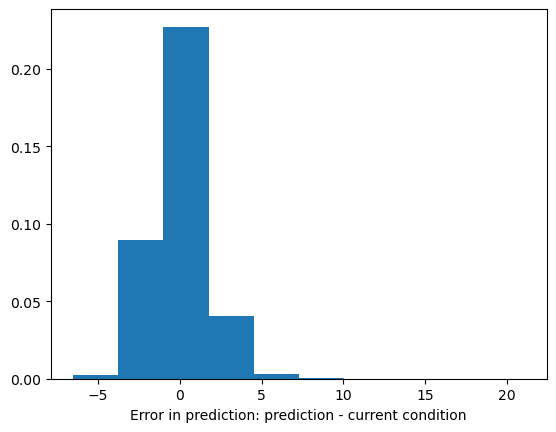

In [ ]:
y_hat = reg.predict(X)

fig,a1 = plt.subplots(1,1)
residuals = y_hat - y
a1.hist(residuals, bins=10, density=True)
_ = a1.set_xlabel('Error in prediction: prediction - current condition')

This graphs shows the residuals from the regression line fit to current condition. Now we can calculate the root of the mean of the square of the errors to compare different models. The root of the mean square error of the regression measures the overall accuracy of the model. So can help us determine how accurately the model with the predictor variables predicts current condition. We will primarily use this as a baseline to determine whether just the continuous variables as a model or both the continuous and categorical variables as a model are more accurate at predicting the current condition.

In [ ]:
# The mean squared error
print('Root of the mean squared error: %.2f'% mean_squared_error(y, y_hat, squared=False))

Root of the mean squared error: 1.59


The RMSE of the continuous variables is 1.59 which indicates that the models predictions on average deviate from the actual values by 1.59 units.

As mentioned before, we can plot the predicted values for current condition based on the predictor variables against the actual values.

Text(0, 0.5, 'Actual Value')

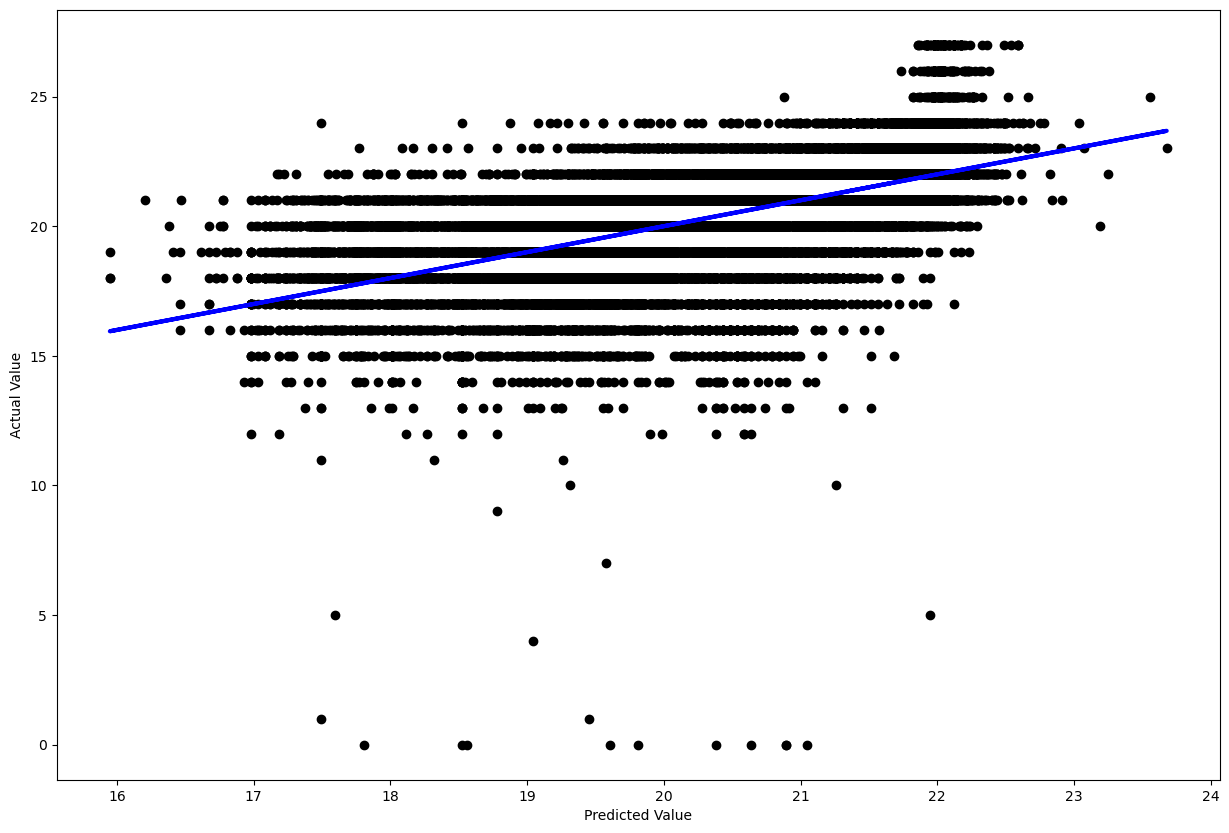

In [ ]:
# Plot outputs
fig, a = plt.subplots(1,1,figsize=(15,10))
a.scatter(y_hat, y,  color='black')
a.plot(y_hat, y_hat, color='blue', linewidth=3)

#can remove the # before these to see the residuals as error bars between plot and expected
#two_std = residuals.std() * 2
#a.errorbar(y_hat, y, yerr=two_std, fmt='.k')

a.set_xlabel('Predicted Value')
a.set_ylabel('Actual Value')

As shown by the RMSE, the difference is 1.59 units, so when we pick a value eg predicted of 20, it will differ by about 1.59 units, so the actual value is more likely to be approximately 21.5. This will be explored more when we introduce the categorical variables also.

#### Standardisation

The disparities of the predictors units made the $\beta$ regression coefficient harder to compare. Another way instead of comparing the ranges is by instead standardising the values. This makes the comparison easier (but interpretation harder). Note that standardisation does not change the goodness of fit. The standardisation converts a predictor  $x$ to $z$
$$z = \frac{x - \bar{x}}{s}$$

where $s$ is the sample standard deviation.tion.

In [ ]:
#Regression rerun with standardisation
Z = StandardScaler().fit_transform(X)

reg1 = LinearRegression().fit(Z, y)
print('The R2 coefficient of determination is %4.3f' % reg.score(X, y))
print('The intercept is %4.1f' % reg1.intercept_)
beta_AgeT, beta_AverageDailyT, beta_Trucks_percentT = reg1.coef_
print('Estimated regression coefficient for standardised Age is %4.2f' % beta_AgeT)
print('Estimated regression coefficient for standardised Average Daily is %4.2f' % beta_AverageDailyT)# AVG DAILY
print('Estimated regression coefficient for standardised Trucks percent is %4.2f' % beta_Trucks_percentT)



The R2 coefficient of determination is 0.354
The intercept is 20.3
Estimated regression coefficient for standardised Age is -1.21
Estimated regression coefficient for standardised Average Daily is 0.00
Estimated regression coefficient for standardised Trucks percent is 0.18


So, as shown with the continuous predictor variables standardised, the degree of influence that Average Daily, Age and Trucks percent have on the variability of the current condition of a bridge is unchanged as compared to before standardisation. So 35.4% of the changes in current condition of a bridge can be explained by these predictor variables. As mentioned before standardisation does not change the fit of the model.

In terms of the intercept, if the 3 predictor variables are set to 0, then the expected mean value of current condition is expected to be 20.3., which is 2 lower than before standardisation. So this is the value that current condition would be expected to have if the predictor variables had no influence when standardised.

The estimated regression coefficients are important to answering the initial questions asked. The estimated standardised Age coefficient has increased in influence and is now -1.21. This indicates that for one year increase in Age, the current condition of bridges is expected to decrease by 1.21. The estimated coefficient for standardised Daily Average has not changed and still suggests that it has no significant influence on the change in current condition.  The estimated coefficient for standardised Trucks Percent has increased from 0.02 to 0.18 suggesting an increase in influence on current condition when standardised. This still indicates that changes in these three continuous predictor variables are not strongly correlated with changes in the current condition of the bridges, as there was not a significant change for the variables coefficients once standardised.

#### 3.1.2: Categorical and Continuous Regression

Now we have seen the impact of the continuous predictor variables in the regression model, we want to determine how the categorical predictor variables affect these values.

To insert categorical predictors into a regression they must be transformed using reference encoding. For reference encoding we use the first value of the categorical variable as a reference, so this is dropped from the dummy variables. However, pandas drops the first alphabetical category and we do not want to do this for the categorical variables, as it will drop Concrete and Beam (the largest categories). So instead, we drop the smallest category in order to determine the effects of the larger categories, which was predicted earlier to be more likely to have a larger effect . We do this for both categorical predictors reducing the 3 categories down to 2 each.

In [ ]:
mat = pd.get_dummies(brd_logs.Material, dtype=int, drop_first=False)
mat = mat.drop(['Timber'], axis=1)
mat

,Concrete,Steel
Structure_id,,
000021521-00101,1,0
000021521-00181,1,0
000021521-TMP20,1,0
000021525-00012,0,0
000021580-00092,1,0
...,...,...
DAPFORHOO000012,1,0
DAPFORHOO000013,1,0
DAPFORHOO000015,1,0


In [ ]:
des = pd.get_dummies(brd_logs.Design, dtype=int, drop_first=False)
des = des.drop(['Other'], axis=1)
des

,Beam,Slab
Structure_id,,
000021521-00101,0,1
000021521-00181,0,1
000021521-TMP20,1,0
000021525-00012,1,0
000021580-00092,1,0
...,...,...
DAPFORHOO000012,1,0
DAPFORHOO000013,1,0
DAPFORHOO000015,1,0


We now add the four new variables to the original regression that was run (not the standardised version).

In [ ]:
#added new dummy categoricals to original regression
np.set_printoptions(suppress=True) #ensures that it prints numbers with no scientific notation

X2 = np.column_stack((des.Beam, des.Slab, mat.Steel, mat.Concrete, brd_logs.Age, brd_logs.AverageDaily, brd_logs.Trucks_percent))
reg2 = LinearRegression().fit(X2, y)
print('The R2 coefficient of determination is %4.3f' % reg2.score(X2, y))
print('The intercept is %4.1f' % reg2.intercept_)

print('The regression coefficients are:', reg2.coef_)

The R2 coefficient of determination is 0.446
The intercept is 19.9
The regression coefficients are: [-0.09725322 -0.17079297  1.46428497  2.83132958 -0.04877274 -0.00000067
  0.00543947]


Introducing the categorical variables has resulted in a change in the regression coefficients, R2 coefficient and the intercept.

So, as shown with the continuous predictor variables only, the degree of influence that Average Daily, Age and Trucks percent have on the variability of the current condition of a bridge is 35.4% in the model. The inclusion of the categorical variables has increased this to 44.6%, showing that all 5 predictor variables can explain this much variance in the current condition of the bridges. This indicates that this model with all 5 predictor variables is a better fit. In terms of the intercept, the number has decreased to 19.9 as compared to the 22.3 of just the continuous variables.

The estimated regression coefficienthave all changed in value with the new added estimated regression coefficients of the categorical variables included. For the categorical variables, the values are novel. For Design, Beam's regression coefficient is -0.097 approx. This indicates that for a bridge being classified as Beam it is likely to decrease the current condition of the bridge by 0.097 approximately. Also, Design category Slab's regression coefficient is -0.17 approx. They both have a very minor effect individually on current condition changes. For Material, Steel has a regression coefficient of 1.46 (approx), meaning that as a bridge is classified as Steel, it is likely to impact current condition by 1.46 (approx). For Material, Concrete has a regression coefficient of 2.83 approx, which is the highest coefficient of all predictor variables. This suggests that as a bridge is classified as Concrete it is likely to increase the current condition of the bridge by 2.83 approx.

The continuous predictor variables' regression coefficients have all changed as a result of adding the categorical variables to the regression model. . The estimated Age coefficient indicates that for one year increase in Age, the current condition of bridges is expected to decrease b'y 048' (approx) which is marginally smaller that the previous regression coefficient estimate05, so has a negative relationship to current condition. The estimate coefficient for Daily Avera has increased from an absolute 0 value to -0.00000067 which stillge suggests that it has no significant influence on the change in current conditi, and is negligeableon. So if Daily Average changes, it will not have visualan effect on current conditi, unless the change is substantialon. The estimate coefficient for Trucks Perce has dropped and nownt estimates that with an increase of 1% to Trucks percent, there is an expected increase of 00502% to current condition. This indicates that changes ithe e continuous predictor variables are not strongly correlated with changes in the current condition of the bridg, in the new model with categorical variables. The categorical variables have a larger influence on the current condition in comparison, with Concrete having the largest influence.s.

In order to answer the other question of how well the predictor variables can predict the bridge condition with all the variables in the new model, we need to look at prediction and error distributions again. We can use the predict method to return the predicted values of the target variable. Then we can calculate the errors and show their distribution as a histogram, which can be compared to the previous model of just continuous predictor variables.

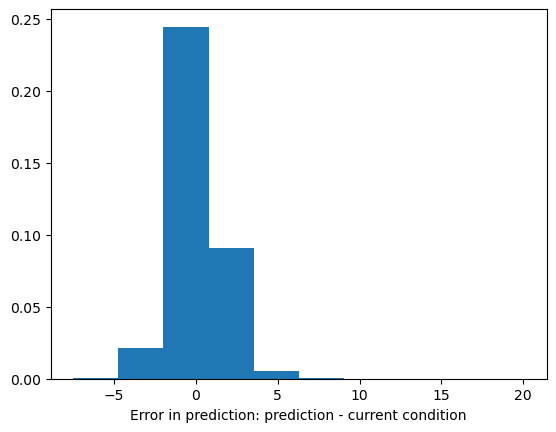

In [ ]:
#Error distribution and prediction - all predictor variables
y_hat2 = reg2.predict(X2)

fig,a1 = plt.subplots(1,1)
residuals = y_hat2 - y
a1.hist(residuals, bins=10, density=True)
_ = a1.set_xlabel('Error in prediction: prediction - current condition')

This graphs shows the residuals from the new regression line fit to current condition. Now we can calculate the root of the mean of the square of the errors to compare the different models. As we can see comparing the histograms, the model fits better and has lower errors as compared to the actual values, using all the predictor variables. We also want to compare the RMSE of the two models as this shows the fit of the model and how well the model's predictions deviate from the actual values.

In [ ]:
# The mean squared error of new model
print('Root of the mean squared error: %.2f'% mean_squared_error(y, y_hat2, squared=False))

Root of the mean squared error: 1.48


The RMSE of the continuous variables is 1.48, which is 0.11 lower than the model with just the continuous predictor variables. This indicates that the models predictions on average deviate from the actual values by 1.48 units, which is lower in comparison. This can be indicative of the fact that this model is a better fit and more accurate in comparison.

As mentioned before, we can plot the predicted values for current condition based on the predictor variables against the actual values.

Text(0, 0.5, 'Actual Value')

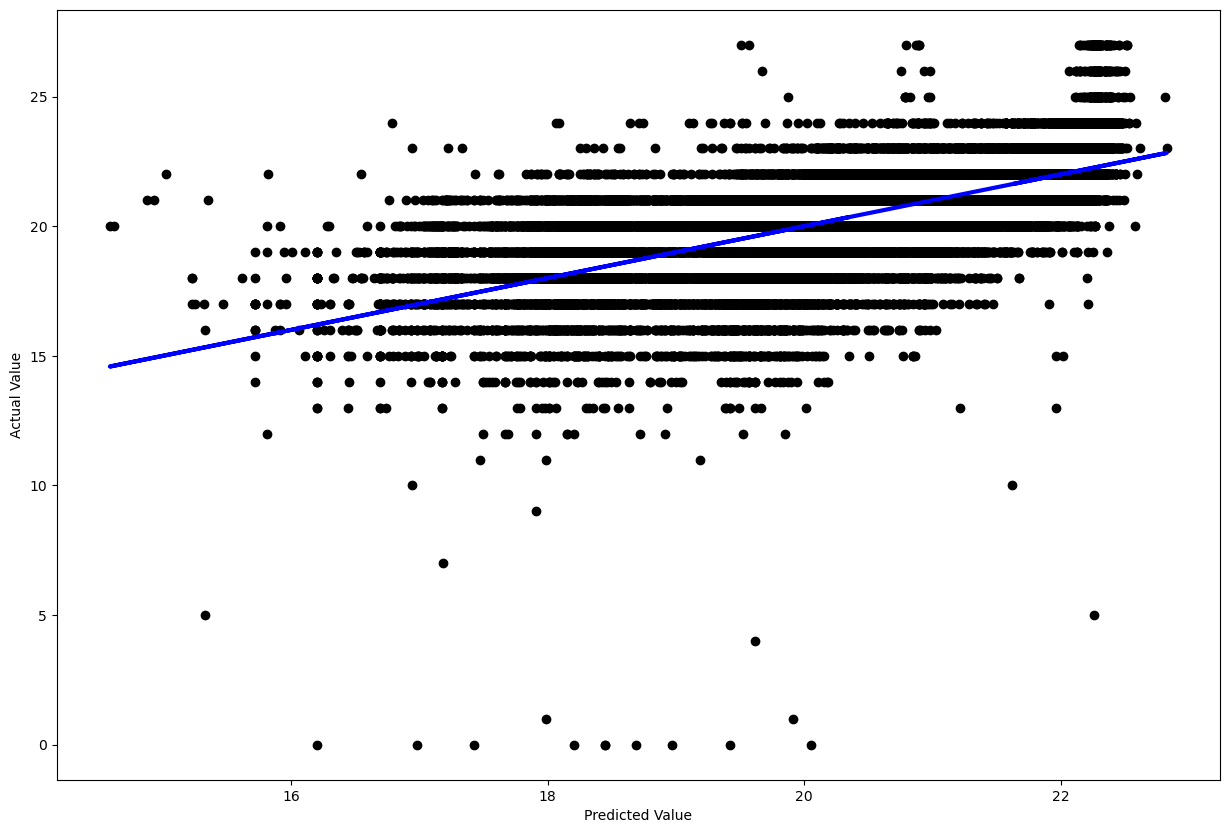

In [ ]:
# Plot outputs
fig, a = plt.subplots(1,1,figsize=(15,10))
a.scatter(y_hat2, y,  color='black')
a.plot(y_hat2, y_hat2, color='blue', linewidth=3)

#can remove the # before these to see the residuals as error bars between plot and expected
#two_std = residuals.std() * 2
#a.errorbar(y_hat, y, yerr=two_std, fmt='.k')

a.set_xlabel('Predicted Value')
a.set_ylabel('Actual Value')


As shown by the RMSE, the difference is 1.48 units, so when we pick a value eg predicted of 20, it will differ by about 1.48 units. This is better than the model that had only the continuous variables, however as shown below, the highest value for current condition is 27, so although this model is more accurate it can be considered a moderate fit due to the fact that the target variable's ratings do not go especially high. If the ratings went to a higher number, then the RMSE would be indicative of an especially accurate model, but due to the context of the model, it is simply moderately accurate.

In [ ]:
new_bridges["current_condition"].max()

27

### 3.2: Final Conclusions

Based on all the analysis run, final conclusions can now be drawn to answer the questions asked in regards to the dataset. The main questions asked were how well the proposed predictor variables -of Age, Average Use (Average Daily), Percent Trucks (Trucks percent), Material and Design- could predict the bridge condition. The other question asked was which of the proposed variables has more of an influence on the current condition.

In relation to the how well the predictors could predict the bridge condition, the model with all 5 predictor variables indicated that these variables could explain 44.6% of the variance in the current bridge condition. This was compared to the model of just three of the predictor variables: Age, Daily Average and Trucks percent, which indicated that these variables could explain 35.4% of the variance in the current bridge condition. This indicated that all 5 variables can moderately predict the current bridge condition with almost half of the variation being explainable by these variables. However, the highest value for current condition is 27, so although this model is more accurate as shown through RMSE comparisons, it can be considered a moderate fit due to the fact that the target variable's ratings do not go especially high. So, due to the context of the model, it is simply moderately accurate. The dataset has many variables and it may be a feasible idea to run analysis with other variables to see if another model with other predictor variables can account for a higher percentage of the variance in the current condition variable and consequently a lower RMSE.

As seen through all the regression analysis, of all 5 predictor values, they each had a differing influence on the current condition of bridges. Material has the largest influence on the current condition, with Concrete having a regression coefficient of 2.83 approximately, and Steel having a regression coefficient of 1.46. This indicates that Material has a positive relationship with the current condition variable. Design also had an influence on the condition of bridges also with slightly lower coefficients. However as seen by all individual coefficients, the coefficients are relatively small, suggesting limited influence on the bridge condition. Altogether, they had a higher impact, but individually the influence was not overly significant. Further analysis should be undertaken into understanding how the combination of these variables could significantly affect the current condition. It should also be compared in other models to see if compared to other variables in the dataset, it may be more or less predictive than other variables.

Overall, the models provided insight into how the predictor variables influence the bridge condition, but showed a moderate explained variance. The inclusion of Design and Material showed a more substantial impact and increased the models ability to explain variance in current condition. However, further analysis is likely necessary to uncover more indicative predictor variables or to improve the models predictive performance.